<a href="https://colab.research.google.com/github/sraghav42/machine_learning/blob/master/sentimentanalysis_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
!pip install --quiet bert-for-tf2
!pip install --quiet sentencepiece

In [0]:
import tensorflow_hub as hub
import bert
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random

In [15]:
!wget --quiet "https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip"
!unzip -q "sentiment labelled sentences"
!mv "sentiment labelled sentences" data
!ls -l data

replace __MACOSX/sentiment labelled sentences/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
total 212
-rw-r--r-- 1 root root 58226 Jul  5  2016  amazon_cells_labelled.txt
-rw-r--r-- 1 root root 85285 Feb 15  2015  imdb_labelled.txt
-rw-r--r-- 1 root root  1070 May 31  2015  readme.txt
drwxr-xr-x 2 root root  4096 Jul  5  2016 'sentiment labelled sentences'
-rw-r--r-- 1 root root 61320 Jul  5  2016  yelp_labelled.txt


In [16]:
files = ['data/yelp_labelled.txt', 'data/amazon_cells_labelled.txt', 'data/imdb_labelled.txt']

df_list = []
for file in files:
    df = pd.read_csv(file, names=['comment', 'sentiment'], sep='\t')
    df_list.append(df)

data = pd.concat(df_list)
data['length'] = data.comment.str.split(' ').str.len()

max_seq_length = 128

# Keep only short comments
shortComments = data[data.length < max_seq_length-5]
print('Number of rows: %d' % len(shortComments))

shortComments.head()

Number of rows: 2743


,comment,sentiment,length
0,Wow... Loved this place.,1,4
1,Crust is not good.,0,4
2,Not tasty and the texture was just nasty.,0,8
3,Stopped by during the late May bank holiday of...,1,15
4,The selection on the menu was great and so wer...,1,12


In [0]:
comments = shortComments.comment.astype(str).tolist()
sentiments = shortComments.sentiment.tolist()
labels = np.asarray(sentiments)

x_train, x_test, y_train, y_test = train_test_split(comments, labels, test_size=0.2, random_state=42)

In [0]:
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(bert_path, trainable=False, name='BERT')
vocab_file1 = bert_layer.resolved_object.vocab_file.asset_path.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file1, do_lower_case=True)

In [0]:
def encodeText(textList):
  token_list = []
  att_list = []
  segment_list = []
  for text in textList:
    tokens = tokenizer.tokenize(text)
    padding = ['[PAD]'] * (max_seq_length - len(tokens) - 2)
    token_ids = tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'] + padding)
    token_list.append(token_ids)

    att_mask = [int(id > 0) for id in token_ids]
    att_list.append(att_mask)

    segment_ids = [0]*max_seq_length
    segment_list.append(segment_ids)
  return [tf.cast(token_list,tf.int32), tf.cast(att_list,tf.int32), tf.cast(segment_list,tf.int32)]

In [20]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_segment_ids])

l1 = Lambda(lambda seq: seq[:, 0, :])(sequence_output)
output = Dense(2, activation='softmax')(l1)
model = Model([input_word_ids, input_mask, input_segment_ids], output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [0]:
history = model.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Epoch 1/5
732/732 [==============================] - 36s 49ms/step - loss: 0.3638 - accuracy: 0.8592 - val_loss: 0.2970 - val_accuracy: 0.8780
Epoch 2/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2430 - accuracy: 0.9107 - val_loss: 0.2600 - val_accuracy: 0.8980
Epoch 3/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2164 - accuracy: 0.9175 - val_loss: 0.2582 - val_accuracy: 0.9053
Epoch 4/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2008 - accuracy: 0.9275 - val_loss: 0.2452 - val_accuracy: 0.8980
Epoch 5/5
732/732 [==============================] - 35s 47ms/step - loss: 0.1907 - accuracy: 0.9289 - val_loss: 0.2834 - val_accuracy: 0.8816


Fine tuning the model by unfreezing the BERT layer

In [21]:
bert_layer.trainable = True
output.trainable = False
model2 = Model([input_word_ids, input_mask, input_segment_ids], output)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [22]:
history2 = model2.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Epoch 1/5
732/732 [==============================] - 110s 151ms/step - loss: 0.2150 - accuracy: 0.9166 - val_loss: 0.1663 - val_accuracy: 0.9399
Epoch 2/5
732/732 [==============================] - 109s 149ms/step - loss: 0.0411 - accuracy: 0.9900 - val_loss: 0.1703 - val_accuracy: 0.9545
Epoch 3/5
732/732 [==============================] - 110s 150ms/step - loss: 0.0062 - accuracy: 0.9973 - val_loss: 0.2473 - val_accuracy: 0.9435
Epoch 4/5
732/732 [==============================] - 110s 150ms/step - loss: 2.9334e-04 - accuracy: 1.0000 - val_loss: 0.2832 - val_accuracy: 0.9508
Epoch 5/5
732/732 [==============================] - 109s 150ms/step - loss: 9.7072e-05 - accuracy: 1.0000 - val_loss: 0.3054 - val_accuracy: 0.9508


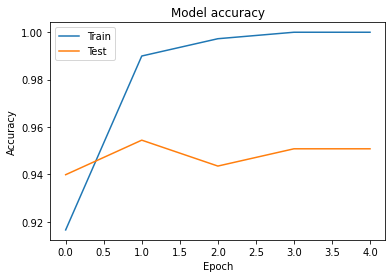

In [23]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
predictions = model2.predict(encodeText(x_test))
most_likely = predictions.argmax(1)

In [26]:
index = random.randrange(len(predictions))
print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

Disappointing experience.
Prediction: 0, label: 0


Error Analysis

The plastic breaks really easy on this clip.
Prediction: 1, label: 0


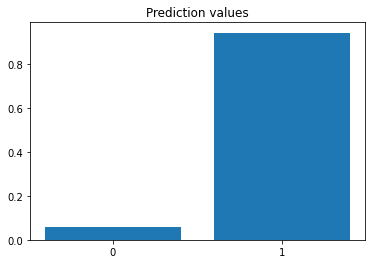

In [28]:
for i in range(1000):
    index = random.randrange(len(predictions))
    if most_likely[index] != y_test[index]:
        break

print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

plt.bar(range(2), predictions[index], tick_label=range(2))
plt.title('Prediction values')
plt.show()

In [29]:
text = []
labels = []
preds = []
for i in range(len(predictions)):
  if most_likely[i] != y_test[i]:
    text.append(x_test[i])
    labels.append(y_test[i])
    preds.append(most_likely[i])

errors = pd.DataFrame({'Comment':text, 'Sentiment':labels, 'Predictions':preds})
errors.head()

,Comment,Sentiment,Predictions
0,It definitely was not as good as my S11.,1,0
1,For a product that costs as much as this one d...,0,1
2,You get extra minutes so that you can carry ou...,1,0
3,This place deserves one star and 90% has to do...,0,1
4,The lead man is charisma-free.,0,1
